## This file contains feature engineering, LSTM Stacked Autoencoder (LSTM-SAE) and the Transformer

## Authors: Zhihao Xu, Shiyu Dou

### Sources:
Mixed Precision for Transformer
https://ieeexplore.ieee.org/document/9414076
https://nvidia.github.io/OpenSeq2Seq/html/machine-translation/transformer.html#mixed-precision

PyTorch https://towardsdatascience.com/a-comprehensive-guide-to-neural-machine-translation-using-seq2sequence-modelling-using-pytorch-41c9b84ba350

https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/

https://medium.com/deep-learning-with-keras/lstm-understanding-output-types-e93d2fb57c77

https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/


## Preperation

In [ ]:
!pip install keras-attention
import random
import numpy as np
import matplotlib.pyplot as plt
import os
# 只使用第三块GPU。
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import pickle as pkl
import keras
import pandas as pd, numpy as np
import seaborn as sns
from keras import layers
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
import pydot as pyd
from keras.utils.vis_utils import plot_model, model_to_dot
from keras.layers import Dense
from keras.layers import Attention
keras.utils.vis_utils.pydot = pyd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import GridSearchCV, KFold
from google.colab import files

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Apr 28 22:31:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
# Alternative option to access files in Google Drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
import pandas as pd
import numpy as np
fileDownloaded = drive.CreateFile({'id':'17djwlsxAR6IQWF_UOH4JpwWU1X9GdQGl'})
fileDownloaded.GetContentFile('test.csv')
test_comp = pd.read_csv('test.csv')

fileDownloaded = drive.CreateFile({'id':'1OaSAZQthzltrNl97-dUL85CP9x_JD021'})
fileDownloaded.GetContentFile('train.csv')
train_comp = pd.read_csv('train.csv')

print(train_comp.shape)
print(test_comp.shape)

(4828800, 8)
(1207200, 8)


## Feature Engineering

In [ ]:
def add_features(df):
    df['cross']= df['u_in'] * df['u_out']
    df['cross2']= df['time_step'] * df['u_out']
    df['area'] = df['time_step'] * df['u_in']
    df['area'] = df.groupby('breath_id')['area'].cumsum()
    df['time_step_cumsum'] = df.groupby(['breath_id'])['time_step'].cumsum()
    df['u_in_cumsum'] = (df['u_in']).groupby(df['breath_id']).cumsum()
    print("Step-1...Completed")
    
    df['u_in_lag1'] = df.groupby('breath_id')['u_in'].shift(1)
    df['u_out_lag1'] = df.groupby('breath_id')['u_out'].shift(1)
    df['u_in_lag_back1'] = df.groupby('breath_id')['u_in'].shift(-1)
    df['u_out_lag_back1'] = df.groupby('breath_id')['u_out'].shift(-1)
    df['u_in_lag2'] = df.groupby('breath_id')['u_in'].shift(2)
    df['u_out_lag2'] = df.groupby('breath_id')['u_out'].shift(2)
    df['u_in_lag_back2'] = df.groupby('breath_id')['u_in'].shift(-2)
    df['u_out_lag_back2'] = df.groupby('breath_id')['u_out'].shift(-2)
    df['u_in_lag3'] = df.groupby('breath_id')['u_in'].shift(3)
    df['u_out_lag3'] = df.groupby('breath_id')['u_out'].shift(3)
    df['u_in_lag_back3'] = df.groupby('breath_id')['u_in'].shift(-3)
    df['u_out_lag_back3'] = df.groupby('breath_id')['u_out'].shift(-3)
    df['u_in_lag4'] = df.groupby('breath_id')['u_in'].shift(4)
    df['u_out_lag4'] = df.groupby('breath_id')['u_out'].shift(4)
    df['u_in_lag_back4'] = df.groupby('breath_id')['u_in'].shift(-4)
    df['u_out_lag_back4'] = df.groupby('breath_id')['u_out'].shift(-4)
    df = df.fillna(0)
    print("Step-2...Completed")
    
    df['breath_id__u_in__max'] = df.groupby(['breath_id'])['u_in'].transform('max')
    df['breath_id__u_in__mean'] = df.groupby(['breath_id'])['u_in'].transform('mean')
    df['breath_id__u_in__diffmax'] = df.groupby(['breath_id'])['u_in'].transform('max') - df['u_in']
    df['breath_id__u_in__diffmean'] = df.groupby(['breath_id'])['u_in'].transform('mean') - df['u_in']

    print("Step-3...Completed")
    
    df['u_in_diff1'] = df['u_in'] - df['u_in_lag1']
    df['u_out_diff1'] = df['u_out'] - df['u_out_lag1']
    df['u_in_diff2'] = df['u_in'] - df['u_in_lag2']
    df['u_out_diff2'] = df['u_out'] - df['u_out_lag2']
    df['u_in_diff3'] = df['u_in'] - df['u_in_lag3']
    df['u_out_diff3'] = df['u_out'] - df['u_out_lag3']
    df['u_in_diff4'] = df['u_in'] - df['u_in_lag4']
    df['u_out_diff4'] = df['u_out'] - df['u_out_lag4']
    print("Step-4...Completed")
    
    df['one'] = 1
    df['count'] = (df['one']).groupby(df['breath_id']).cumsum()
    df['u_in_cummean'] =df['u_in_cumsum'] /df['count']
    
    df['breath_id_lag']=df['breath_id'].shift(1).fillna(0)
    df['breath_id_lag2']=df['breath_id'].shift(2).fillna(0)
    df['breath_id_lagsame']=np.select([df['breath_id_lag']==df['breath_id']],[1],0)
    df['breath_id_lag2same']=np.select([df['breath_id_lag2']==df['breath_id']],[1],0)
    df['breath_id__u_in_lag'] = df['u_in'].shift(1).fillna(0)
    df['breath_id__u_in_lag'] = df['breath_id__u_in_lag'] * df['breath_id_lagsame']
    df['breath_id__u_in_lag2'] = df['u_in'].shift(2).fillna(0)
    df['breath_id__u_in_lag2'] = df['breath_id__u_in_lag2'] * df['breath_id_lag2same']
    print("Step-5...Completed")
    
    df['time_step_diff'] = df.groupby('breath_id')['time_step'].diff().fillna(0)
    df['ewm_u_in_mean'] = (df\
                           .groupby('breath_id')['u_in']\
                           .ewm(halflife=9)\
                           .mean()\
                           .reset_index(level=0,drop=True))
    df[["15_in_sum","15_in_min","15_in_max","15_in_mean"]] = (df\
                                                              .groupby('breath_id')['u_in']\
                                                              .rolling(window=15,min_periods=1)\
                                                              .agg({"15_in_sum":"sum",
                                                                    "15_in_min":"min",
                                                                    "15_in_max":"max",
                                                                    "15_in_mean":"mean"
                                                                    #"15_in_std":"std"
                                                               })\
                                                               .reset_index(level=0,drop=True))
    print("Step-6...Completed")
        
    df['u_in_lagback_diff1'] = df['u_in'] - df['u_in_lag_back1']
    df['u_out_lagback_diff1'] = df['u_out'] - df['u_out_lag_back1']
    df['u_in_lagback_diff2'] = df['u_in'] - df['u_in_lag_back2']
    df['u_out_lagback_diff2'] = df['u_out'] - df['u_out_lag_back2']
    print("Step-7...Completed")
    
    df['R_str'] = df['R'].astype(str)
    df['C_str'] = df['C'].astype(str)
    df['R__C'] = df["R"].astype(str) + '__' + df["C"].astype(str)
    df = pd.get_dummies(df)
    print("Step-8...Completed")
    
    return df

In [ ]:
# Original dataset is ordered so sample not at random
#iter_train = 20000
#iter_test = 2000

train = train_comp
test = test_comp
#train = train_comp.iloc[0:(iter_train*80), :]
#test = test_comp.iloc[0:(iter_test*80), :]

print(train.shape)
print(test.shape)

(4828800, 8)
(1207200, 8)


In [ ]:
train = add_features(train)
test = add_features(test)

Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed
Step-6...Completed
Step-7...Completed
Step-8...Completed
Step-1...Completed
Step-2...Completed
Step-3...Completed
Step-4...Completed
Step-5...Completed
Step-6...Completed
Step-7...Completed
Step-8...Completed


In [ ]:
print(train.columns)
print(train.shape)

Index(['Unnamed: 0', 'breath_id', 'R', 'C', 'time_step', 'u_in', 'u_out',
       'pressure', 'cross', 'cross2', 'area', 'time_step_cumsum',
       'u_in_cumsum', 'u_in_lag1', 'u_out_lag1', 'u_in_lag_back1',
       'u_out_lag_back1', 'u_in_lag2', 'u_out_lag2', 'u_in_lag_back2',
       'u_out_lag_back2', 'u_in_lag3', 'u_out_lag3', 'u_in_lag_back3',
       'u_out_lag_back3', 'u_in_lag4', 'u_out_lag4', 'u_in_lag_back4',
       'u_out_lag_back4', 'breath_id__u_in__max', 'breath_id__u_in__mean',
       'breath_id__u_in__diffmax', 'breath_id__u_in__diffmean', 'u_in_diff1',
       'u_out_diff1', 'u_in_diff2', 'u_out_diff2', 'u_in_diff3', 'u_out_diff3',
       'u_in_diff4', 'u_out_diff4', 'one', 'count', 'u_in_cummean',
       'breath_id_lag', 'breath_id_lag2', 'breath_id_lagsame',
       'breath_id_lag2same', 'breath_id__u_in_lag', 'breath_id__u_in_lag2',
       'time_step_diff', 'ewm_u_in_mean', '15_in_sum', '15_in_min',
       '15_in_max', '15_in_mean', 'u_in_lagback_diff1', 'u_out_lagback_d

In [ ]:
# Drop the intermediate variables
X_train = train.drop(['breath_id', 'Unnamed: 0', 'pressure', 'breath_id_lag', 'breath_id_lag2','breath_id_lagsame',
            'breath_id_lag2same', 'one'], axis = 1)
y_train = train[['pressure']]

X_test = test.drop(['breath_id', 'Unnamed: 0', 'pressure', 'breath_id_lag', 'breath_id_lag2','breath_id_lagsame',
            'breath_id_lag2same', 'one'], axis = 1)
y_test = test[['pressure']]

In [ ]:
print(X_train.columns)
print(X_train.shape)
print(y_train.columns)
print(y_train.shape)

Index(['R', 'C', 'time_step', 'u_in', 'u_out', 'cross', 'cross2', 'area',
       'time_step_cumsum', 'u_in_cumsum', 'u_in_lag1', 'u_out_lag1',
       'u_in_lag_back1', 'u_out_lag_back1', 'u_in_lag2', 'u_out_lag2',
       'u_in_lag_back2', 'u_out_lag_back2', 'u_in_lag3', 'u_out_lag3',
       'u_in_lag_back3', 'u_out_lag_back3', 'u_in_lag4', 'u_out_lag4',
       'u_in_lag_back4', 'u_out_lag_back4', 'breath_id__u_in__max',
       'breath_id__u_in__mean', 'breath_id__u_in__diffmax',
       'breath_id__u_in__diffmean', 'u_in_diff1', 'u_out_diff1', 'u_in_diff2',
       'u_out_diff2', 'u_in_diff3', 'u_out_diff3', 'u_in_diff4', 'u_out_diff4',
       'count', 'u_in_cummean', 'breath_id__u_in_lag', 'breath_id__u_in_lag2',
       'time_step_diff', 'ewm_u_in_mean', '15_in_sum', '15_in_min',
       '15_in_max', '15_in_mean', 'u_in_lagback_diff1', 'u_out_lagback_diff1',
       'u_in_lagback_diff2', 'u_out_lagback_diff2', 'R_str_20', 'R_str_5',
       'R_str_50', 'C_str_10', 'C_str_20', 'C_str_50', '

In [ ]:
RS = RobustScaler()
X_train = RS.fit_transform(X_train.astype('float32'))
X_test = RS.transform(X_test.astype('float32'))

X_train = X_train.reshape(-1, 80, X_train.shape[-1])
X_test = X_test.reshape(-1, 80, X_test.shape[-1])

In [ ]:
y_train = y_train.to_numpy().reshape(-1, 80, 1)
y_test = y_test.to_numpy().reshape(-1, 80, 1)

## LSTM w/ Bottleneck w/o Activation

In [ ]:
input_train = Input(shape=(X_train.shape[1], X_train.shape[2]))
output_train = Input(shape=(y_train.shape[1], y_train.shape[2]))
print(input_train)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 80, 67), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 80, 1), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")


In [ ]:
# There's one additional rule of thumb that helps for supervised learning problems. 
# You can usually prevent over-fitting if you keep your number of neurons below:
# N_hidden = N_sample_in_train (2 or 5-10) /(alpha * (#of input neurons + #of output neurons))

n_hidden = 150

In [ ]:
# LSTM return_state=True + return_sequences=True value:
# In this situation, LSTM layer returns 3 results:
# (as return_sequences=True)
# the hidden states for each input time step,
# (as return_state=True) 2. the hidden state output for the last time step and 3. the cell state for the last time step.

encoder_all_state_h1, encoder_h1, encoder_c1 = LSTM(n_hidden, 
                                                # this will, in fact, will be a dropout rate of 0.2 (set 20% of inputs to zero).
                                                #dropout=0.2, recurrent_dropout=0.2, activation='gelu', 
    return_state=True, return_sequences=True)(input_train)

#encoder_h1 = BatchNormalization(momentum=0.9)(encoder_h1)
#encoder_c1 = BatchNormalization(momentum=0.9)(encoder_c1)

print(encoder_all_state_h1)
print(encoder_h1)
print(encoder_c1)

KerasTensor(type_spec=TensorSpec(shape=(None, 80, 150), dtype=tf.float32, name=None), name='lstm/PartitionedCall:1', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 150), dtype=tf.float32, name=None), name='lstm/PartitionedCall:2', description="created by layer 'lstm'")
KerasTensor(type_spec=TensorSpec(shape=(None, 150), dtype=tf.float32, name=None), name='lstm/PartitionedCall:3', description="created by layer 'lstm'")


In [ ]:
encoder_all_state_h2, encoder_h2, encoder_c2 = LSTM(n_hidden, 
                                                #dropout=0.2, recurrent_dropout=0.2, 
    return_state=True, return_sequences=True)(encoder_all_state_h1)

#encoder_h2 = BatchNormalization(momentum=0.9)(encoder_h2)
#encoder_c2 = BatchNormalization(momentum=0.9)(encoder_c2)

print(encoder_all_state_h2)
print(encoder_h2)
print(encoder_c2)

KerasTensor(type_spec=TensorSpec(shape=(None, 80, 150), dtype=tf.float32, name=None), name='lstm_1/PartitionedCall:1', description="created by layer 'lstm_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 150), dtype=tf.float32, name=None), name='lstm_1/PartitionedCall:2', description="created by layer 'lstm_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 150), dtype=tf.float32, name=None), name='lstm_1/PartitionedCall:3', description="created by layer 'lstm_1'")


In [ ]:
encoder_all_state_h3, encoder_h3, encoder_c3 = LSTM(n_hidden, 
                                                #dropout=0.2, recurrent_dropout=0.2, 
    return_state=True, return_sequences=True)(encoder_all_state_h2)

#encoder_h3 = BatchNormalization(momentum=0.9)(encoder_h3)
#encoder_c3 = BatchNormalization(momentum=0.9)(encoder_c3)

print(encoder_all_state_h3)
print(encoder_h3)
print(encoder_c3)

KerasTensor(type_spec=TensorSpec(shape=(None, 80, 150), dtype=tf.float32, name=None), name='lstm_2/PartitionedCall:1', description="created by layer 'lstm_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 150), dtype=tf.float32, name=None), name='lstm_2/PartitionedCall:2', description="created by layer 'lstm_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 150), dtype=tf.float32, name=None), name='lstm_2/PartitionedCall:3', description="created by layer 'lstm_2'")


In [ ]:
encoder_h3 = BatchNormalization(momentum=0.9)(encoder_h3)
encoder_c3 = BatchNormalization(momentum=0.9)(encoder_c3)

In [ ]:
# The Decoder LSTM, Next, we repeat the last hidden state of encoder 80 times, and use them as input to decoder LSTM.
decoder_input = RepeatVector(output_train.shape[1])(encoder_h3)
print(decoder_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 80, 150), dtype=tf.float32, name=None), name='repeat_vector/Tile:0', description="created by layer 'repeat_vector'")


In [ ]:
# First decoder layer
decoder_all_state_h1, decoder_h1, decoder_c1  = LSTM(n_hidden, 
                                                 #dropout=0.2, recurrent_dropout=0.2,
 return_state=True, return_sequences=True)(
 decoder_input, initial_state = [encoder_h1, encoder_c1])

#decoder_h1 = BatchNormalization(momentum=0.9)(decoder_h1)
#decoder_c1 = BatchNormalization(momentum=0.9)(decoder_c1)

print(decoder_all_state_h1)
print(decoder_h1)
print(decoder_c1)

KerasTensor(type_spec=TensorSpec(shape=(None, 80, 150), dtype=tf.float32, name=None), name='lstm_3/PartitionedCall:1', description="created by layer 'lstm_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 150), dtype=tf.float32, name=None), name='lstm_3/PartitionedCall:2', description="created by layer 'lstm_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 150), dtype=tf.float32, name=None), name='lstm_3/PartitionedCall:3', description="created by layer 'lstm_3'")


In [ ]:
# Second decoder layer
decoder_all_state_h2, decoder_h2, decoder_c2 = LSTM(n_hidden, 
                                                #dropout=0.2, recurrent_dropout=0.2,
 return_state=True, return_sequences=True)(
 decoder_all_state_h1, initial_state = [encoder_h2, encoder_c2])

#decoder_h2 = BatchNormalization(momentum=0.9)(decoder_h2)
#decoder_c2 = BatchNormalization(momentum=0.9)(decoder_c2)

print(decoder_all_state_h2)
print(decoder_h2)
print(decoder_c2)

KerasTensor(type_spec=TensorSpec(shape=(None, 80, 150), dtype=tf.float32, name=None), name='lstm_4/PartitionedCall:1', description="created by layer 'lstm_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 150), dtype=tf.float32, name=None), name='lstm_4/PartitionedCall:2', description="created by layer 'lstm_4'")
KerasTensor(type_spec=TensorSpec(shape=(None, 150), dtype=tf.float32, name=None), name='lstm_4/PartitionedCall:3', description="created by layer 'lstm_4'")


In [ ]:
# Third decoder layer
decoder_all_state_h3 = LSTM(n_hidden, 
                                                #dropout=0.2, recurrent_dropout=0.2,
 return_state=False, return_sequences=True)(
 decoder_all_state_h2, initial_state = [encoder_h3, encoder_c3])

print(decoder_all_state_h3)

KerasTensor(type_spec=TensorSpec(shape=(None, 80, 150), dtype=tf.float32, name=None), name='lstm_5/PartitionedCall:1', description="created by layer 'lstm_5'")


In [ ]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder_all_state_h3)

In [ ]:
Seq2seqLSTM = Model(input_train, out)
# Gradient Norm Scaling changes the derivatives of the loss function to have a given vector norm when the L2 vector norm (sum of the squared values) of the gradient vector exceeds a threshold value. 
# For example, we could specify a norm of 1.0, meaning that if the vector norm for a gradient exceeds 1.0, then the values in the vector will be rescaled so that the norm of the vector equals 1.0.
#opt = Adam()
opt = Adam(lr=0.001, clipnorm=1)
Seq2seqLSTM.compile(loss='mae', optimizer=opt, metrics=['mae'])
Seq2seqLSTM.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 67)]     0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 80, 150),    130800      ['input_1[0][0]']                
                                 (None, 150),                                                     
                                 (None, 150)]                                                     
                                                                                                  
 lstm_1 (LSTM)                  [(None, 80, 150),    180600      ['lstm[0][0]']                   
                                 (None, 150),                                                 

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
epc = 50
# patience: Number of epochs with no improvement after which training will be stopped

# Optimal Batch Size, in most cases, an optimal batch-size is 64.
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
es = EarlyStopping(monitor='val_loss', mode='min', patience = 10)
history = Seq2seqLSTM.fit(X_train[:, :, :], y_train[:, :, :], validation_split = 0.2, 
                    epochs = epc, verbose = 1, callbacks = [es], batch_size = 64)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
Seq2seqLSTM.save('model_forecasting_seq2seq.h5')

Epoch 1/50
755/755 [==============================] - 42s 39ms/step - loss: 1.7473 - mae: 1.7473 - val_loss: 1.3908 - val_mae: 1.3908
Epoch 2/50
755/755 [==============================] - 27s 36ms/step - loss: 0.9709 - mae: 0.9709 - val_loss: 0.9729 - val_mae: 0.9729
Epoch 3/50
755/755 [==============================] - 27s 35ms/step - loss: 0.8469 - mae: 0.8469 - val_loss: 0.8761 - val_mae: 0.8761
Epoch 4/50
755/755 [==============================] - 27s 35ms/step - loss: 0.7735 - mae: 0.7735 - val_loss: 0.7766 - val_mae: 0.7766
Epoch 5/50
755/755 [==============================] - 27s 36ms/step - loss: 0.7302 - mae: 0.7302 - val_loss: 0.7991 - val_mae: 0.7991
Epoch 6/50
755/755 [==============================] - 27s 36ms/step - loss: 0.6822 - mae: 0.6822 - val_loss: 1.0331 - val_mae: 1.0331
Epoch 7/50
755/755 [==============================] - 28s 37ms/step - loss: 0.6429 - mae: 0.6429 - val_loss: 0.7315 - val_mae: 0.7315
Epoch 8/50
755/755 [==============================] - 27s 36ms

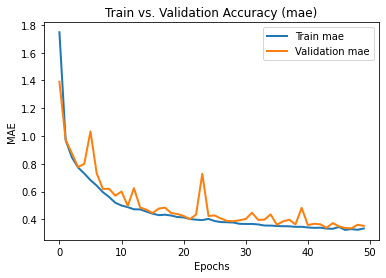

In [ ]:
plt.plot(train_mae, linewidth=2, label='Train mae'), 
plt.plot(valid_mae, linewidth=2, label='Validation mae')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.title('Train vs. Validation Accuracy (mae)')
plt.legend(loc='upper right')
plt.savefig("LSTM1_val.png")
plt.show()

In [ ]:
files.download("LSTM1_val.png") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
X_test_pred = Seq2seqLSTM.predict(X_test)
LSTM_pred_mae = np.mean(np.abs(X_test_pred - y_test), axis = 1)
LSTM_pred_mae.shape

(15090, 1)

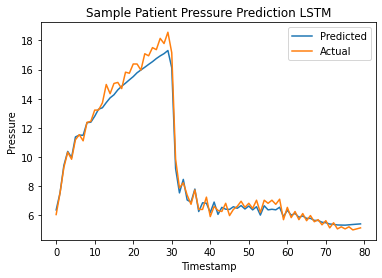

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
plt.plot(X_test_pred[0,:], label='Predicted')
plt.plot(y_test[0,:], label='Actual')
plt.xlabel("Timestamp")
plt.ylabel("Pressure")
plt.legend()
plt.title("Sample Patient Pressure Prediction LSTM")
plt.savefig("LSTM1_pred.png")
plt.show()
files.download("LSTM1_pred.png") 

In [ ]:
pred_mae = test[["R","C"]][test.index % 80 == 0] 
pred_mae["mae"] = LSTM_pred_mae
pred_mae.groupby(['R', 'C']).mean()

mae
R  C           
5  10  0.269214
   20  0.254860
   50  0.274287
20 10  0.277126
   20  0.306025
   50  0.363709
50 10  0.358561
   20  0.503332
   50  0.528446

In [ ]:
np.savetxt("/content/drive/MyDrive/LSTM_SAE.txt", X_test_pred[0,:], delimiter = ", ")

np.savetxt("/content/drive/MyDrive/LSTM_SAE_full.txt", X_test_pred.reshape(len(y_test) * 80, 1), delimiter = ", ")

FileNotFoundError: ignored

### LSTM w/ Bottleneck w/ Activation w/o BatchNormalization

Batch Normalization is Not good for Recurrent Neural Networks

Batch normalization can be applied in between stacks of RNN, where normalization is applied “vertically” i.e. the output of each RNN. But it cannot be applied “horizontally” i.e. between timesteps, as it hurts training because of exploding gradients due to repeated rescaling. 

https://stackoverflow.com/questions/45493384/is-it-normal-to-use-batch-normalization-in-rnn-lstm

No, you cannot use Batch Normalization on a recurrent neural network, as the statistics are computed per batch, this does not consider the recurrent part of the network. Weights are shared in an RNN, and the activation response for each "recurrent loop" might have completely different statistical properties.

Other techniques similar to Batch Normalization that take these limitations into account have been developed, for example Layer Normalization. There are also reparametrizations of the LSTM layer that allow Batch Normalization to be used, for example as described in Recurrent Batch Normalization by Coijmaans et al. 2016.

In [ ]:
input_train = Input(shape=(X_train.shape[1], X_train.shape[2]))
output_train = Input(shape=(y_train.shape[1], y_train.shape[2]))
print(input_train)
print(output_train)

n_hidden = 150

KerasTensor(type_spec=TensorSpec(shape=(None, 80, 67), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 80, 1), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")


In [ ]:
# First LSTM in encoder w/ tanh activation
encoder_all_state_h1, encoder_h1, encoder_c1 = LSTM(n_hidden, activation='tanh',                              
    return_state=True, return_sequences=True)(input_train)

# 2nd LSTM in encoder 
encoder_all_state_h2, encoder_h2, encoder_c2 = LSTM(n_hidden, activation='tanh', 
    return_state=True, return_sequences=True)(encoder_all_state_h1)

# 3rd LSTM in encoder 
encoder_all_state_h3, encoder_h3, encoder_c3 = LSTM(n_hidden, activation='tanh', 
    return_state=True, return_sequences=True)(encoder_all_state_h2)

# Bottleneck layer 
decoder_input = RepeatVector(output_train.shape[1])(encoder_h3)

# First decoder layer
decoder_all_state_h1, decoder_h1, decoder_c1  = LSTM(n_hidden, activation='tanh', 
 return_state=True, return_sequences=True)(
 decoder_input, initial_state = [encoder_h1, encoder_c1])

# Second decoder layer
decoder_all_state_h2, decoder_h2, decoder_c2 = LSTM(n_hidden, activation='tanh', 
 return_state=True, return_sequences=True)(
 decoder_all_state_h1, initial_state = [encoder_h2, encoder_c2])

# Third decoder layer
decoder_all_state_h3 = LSTM(n_hidden, activation='tanh',
 return_state=False, return_sequences=True)(
 decoder_all_state_h2, initial_state = [encoder_h3, encoder_c3])

In [ ]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder_all_state_h3)

In [ ]:
Seq2seqLSTM_act = Model(input_train, out)
opt = Adam(lr=0.001, clipnorm=1)
Seq2seqLSTM_act.compile(loss='mae', optimizer=opt, metrics=['mae'])
Seq2seqLSTM_act.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 80, 67)]     0           []                               
                                                                                                  
 lstm_6 (LSTM)                  [(None, 80, 150),    130800      ['input_3[0][0]']                
                                 (None, 150),                                                     
                                 (None, 150)]                                                     
                                                                                                  
 lstm_7 (LSTM)                  [(None, 80, 150),    180600      ['lstm_6[0][0]']                 
                                 (None, 150),                                               

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
epc = 80
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
history = Seq2seqLSTM_act.fit(X_train[:, :, :], y_train[:, :, :], validation_split = 0.2, 
                    epochs = epc, verbose = 1, callbacks = [es], batch_size = 64)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']
 
Seq2seqLSTM.save('model_forecasting_seq2seq1.h5')

Epoch 1/80
755/755 [==============================] - 46s 52ms/step - loss: 1.5811 - mae: 1.5811 - val_loss: 0.9840 - val_mae: 0.9840
Epoch 2/80
755/755 [==============================] - 37s 49ms/step - loss: 0.8720 - mae: 0.8720 - val_loss: 0.7965 - val_mae: 0.7965
Epoch 3/80
755/755 [==============================] - 37s 49ms/step - loss: 0.7617 - mae: 0.7617 - val_loss: 0.7327 - val_mae: 0.7327
Epoch 4/80
755/755 [==============================] - 37s 49ms/step - loss: 0.6757 - mae: 0.6757 - val_loss: 0.7039 - val_mae: 0.7039
Epoch 5/80
755/755 [==============================] - 37s 49ms/step - loss: 0.6152 - mae: 0.6152 - val_loss: 0.5878 - val_mae: 0.5878
Epoch 6/80
755/755 [==============================] - 37s 49ms/step - loss: 0.5685 - mae: 0.5685 - val_loss: 0.5565 - val_mae: 0.5565
Epoch 7/80
755/755 [==============================] - 37s 49ms/step - loss: 0.5409 - mae: 0.5409 - val_loss: 0.5291 - val_mae: 0.5291
Epoch 8/80
755/755 [==============================] - 37s 49ms

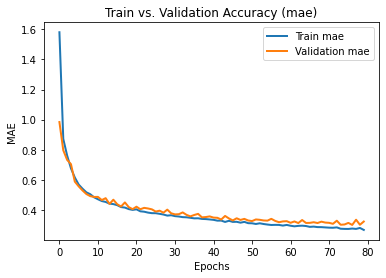

In [ ]:
plt.plot(train_mae, linewidth=2, label='Train mae'), 
plt.plot(valid_mae, linewidth=2, label='Validation mae')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.title('Train vs. Validation Accuracy (mae)')
plt.legend(loc='upper right')
plt.show()

In [ ]:
X_test_pred = Seq2seqLSTM_act.predict(X_test)
LSTM1_pred_mae = np.mean(np.abs(X_test_pred - y_test), axis = 1)
LSTM1_pred_mae.shape

(15090, 1)

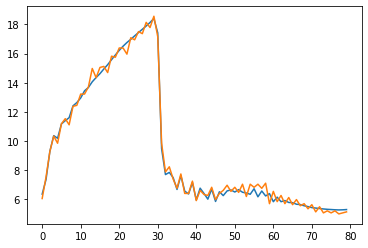

In [ ]:
plt.plot(X_test_pred[0,:], label='Predicted')
plt.plot(y_test[0,:], label='Actual')
plt.xlabel("Timestamp")
plt.ylabel("Pressure")
plt.legend()
plt.title("Sample Patient Pressure Prediction")

In [ ]:
pred_mae1 = test[["R","C"]][test.index % 80 == 0] 
pred_mae1["mae"] = LSTM1_pred_mae
pred_mae1.groupby(['R', 'C']).mean()

mae
R  C           
5  10  0.261722
   20  0.239965
   50  0.274531
20 10  0.287411
   20  0.330996
   50  0.321034
50 10  0.309255
   20  0.430456
   50  0.439176

## Transformer with Mixed Precision w/ Decoder

In [ ]:
import tensorflow as tf

In [ ]:
print(X_train.shape)
print(X_test.shape)
# U_out index is 4
X_train[:, :, 4]

(60360, 80, 67)
(15090, 80, 67)


array([[-1., -1., -1., ...,  0.,  0.,  0.],
       [-1., -1., -1., ...,  0.,  0.,  0.],
       [-1., -1., -1., ...,  0.,  0.,  0.],
       ...,
       [-1., -1., -1., ...,  0.,  0.,  0.],
       [-1., -1., -1., ...,  0.,  0.,  0.],
       [-1., -1., -1., ...,  0.,  0.,  0.]], dtype=float32)

In [ ]:
U_OUT_IDX = 4
# Return an array of ones with the same shape and type as a given array.
y_weight_train = np.ones_like(y_train)
y_weight_test = np.ones_like(y_test)

u_out_values_train = X_train[:, :, U_OUT_IDX]
u_out_values_test = X_test[:, :, U_OUT_IDX]

# Because robust scaler changes u_out: 1 to 0
# Because robust scaler changes u_out: 0 to -1
y_weight_train[u_out_values_train == 0] = 0 
y_weight_test[u_out_values_test == 0] = 0

In [ ]:
# USE MULTIPLE GPUS
if os.environ["CUDA_VISIBLE_DEVICES"].count(',') == 0:
    gpu_strategy = tf.distribute.get_strategy()
    print('single strategy')
else:
    gpu_strategy = tf.distribute.MirroredStrategy()
    print('multiple strategy')

single strategy


In [ ]:
# USE MIXED PRECISION
# UNFORTUNATELY FOR THIS MODEL, MIXED PRECISION HURTS MODEL PERFORMANCE
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
print('Mixed precision enabled')

Mixed precision enabled


In [ ]:
X_train.shape, y_train.shape, y_weight_test.shape

((60360, 80, 67), (60360, 80, 1), (15090, 80, 1))

In [ ]:
class EncoderLayer(layers.Layer):
    def __init__(self, embed_dim, feat_dim, num_heads, ff_dim, rate=0.1):
        super(EncoderLayer, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)

        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="gelu"), layers.Dense(feat_dim), ]
        )

        #epsilon: Small float added to variance to avoid dividing by zero. Defaults to 1e-3
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training, mask = None):
        attn_output = self.att(inputs, inputs, inputs, mask) # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        
        return out2

In [ ]:
class DecoderLayer(layers.Layer):
   def __init__(self, embed_dim, feat_dim, num_heads, ff_dim, rate=0.1):
      super(DecoderLayer, self).__init__()
      self.att1 = layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)
      self.att2 = layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)
      
      self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="gelu"), layers.Dense(feat_dim), ]
        )
  
      self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
      self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
      self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)

      self.dropout1 = layers.Dropout(rate)
      self.dropout2 = layers.Dropout(rate)
      self.dropout3 = layers.Dropout(rate)

   def call(self, inputs, encoder_output, training, look_ahead_mask=None, padding_mask=None):
      attn_output1, attn_weights_block1 = self.att1(inputs, inputs, inputs, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
      attn_output1 = self.dropout1(attn_output1, training=training)
      out1 = self.layernorm1(inputs + attn_output1)

      attn_output2, attn_weights_block2 = self.att2(encoder_output, encoder_output, out1, padding_mask) 
      attn_output2 = self.dropout2(attn_output2, training=training)
      out2 = self.layernorm2(out1 + attn_output2)  # (batch_size, target_seq_len, d_model)

      ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
      ffn_output = self.dropout3(ffn_output, training=training)
      out3 = self.layernorm3(out2 + ffn_output)  # (batch_size, target_seq_len, d_model)

      # , attn_weights_block1, attn_weights_block2
      return out3

In [ ]:
class EncoderDecoder(layers.Layer):
   def __init__(self, embed_dim, feat_dim, num_heads, ff_dim, num_layers, rate=0.1):
      super(EncoderDecoder, self).__init__()
      self.num_layers = num_layers
      self.enc_layers = [EncoderLayer(embed_dim, feat_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
      self.dec_layers = [DecoderLayer(embed_dim, feat_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]

   def call(self, input, training, mask=None, look_ahead_mask=None, padding_mask=None):

     enc_output = input
     #enc_output = np.repeat(input[:,:,np.newaxis], self.num_layers, axis = 2)
     for i in range(self.num_layers):
        enc_old = enc_output
        enc_output = self.enc_layers[i](enc_output, training, mask)
        enc_output = 0.7*enc_output + 0.3*enc_old
     
     for i in range(self.num_layers):
        input_old = input
        input = self.dec_layers[i](input, enc_output, training, look_ahead_mask, padding_mask)
        input = 0.7*input + 0.3*input_old
    
     return input

In [ ]:
print(X_train.shape[-1])

67


In [ ]:
feat_dim = X_train.shape[-1] + 32
embed_dim = 64  # Embedding size for attention
num_heads = 8  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer
dropout_rate = 0.0
num_layers = 12

def build_model():
    inputs = layers.Input(shape = X_train.shape[-2:])
        
    # "EMBEDDING LAYER"
    x = layers.Dense(feat_dim)(inputs)
    x = layers.LayerNormalization(epsilon = 1e-6)(x)

    # ENCODERDECODER BLOCKS
    encoderdecoder = EncoderDecoder(embed_dim, feat_dim, num_heads, ff_dim, num_layers, dropout_rate)
    x = encoderdecoder(x)
    
    # REGRESSION HEAD
    x = layers.Dense(128, activation = "selu")(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation = "linear")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
        
    return model

In [ ]:
EPOCH = 80
BATCH_SIZE = 64
NUM_FOLDS = 11
SEED = 42
VERBOSE = 1

In [ ]:
transformer = build_model()
opt = Adam()
#opt = Adam(lr=0.001, clipnorm=1)
#transformer.compile(optimizer=opt, loss="mae") 
transformer.compile(loss='mae', optimizer=opt, metrics=['mae'])

OperatorNotAllowedInGraphError: ignored

In [ ]:
transformer.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 80, 67)]     0           []                               
                                                                                                  
 dense_2 (Dense)                (None, 80, 99)       6732        ['input_5[0][0]']                
                                                                                                  
 layer_normalization (LayerNorm  (None, 80, 99)      198         ['dense_2[0][0]']                
 alization)                                                                                       
                                                                                                  
 transformer_block (Transformer  (None, 80, 99)      230354      ['layer_normalization[0][0]

In [ ]:
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
es = EarlyStopping(monitor='val_loss', mode='min', patience=30)
transformer_history = transformer.fit(X_train, y_train, verbose=VERBOSE,
                                validation_data=(X_test, y_test), 
                                epochs = EPOCH, batch_size = BATCH_SIZE, callbacks=[reduce_lr])

Epoch 1/80
944/944 [==============================] - 112s 108ms/step - loss: 1.0715 - val_loss: 0.6261 - lr: 0.0010
Epoch 2/80
944/944 [==============================] - 100s 106ms/step - loss: 0.5879 - val_loss: 0.5169 - lr: 9.0000e-04
Epoch 3/80
944/944 [==============================] - 100s 106ms/step - loss: 0.5238 - val_loss: 0.5618 - lr: 8.1000e-04
Epoch 4/80
944/944 [==============================] - 100s 106ms/step - loss: 0.4835 - val_loss: 0.4660 - lr: 7.2900e-04
Epoch 5/80
944/944 [==============================] - 100s 106ms/step - loss: 0.4515 - val_loss: 0.4416 - lr: 6.5610e-04
Epoch 6/80
944/944 [==============================] - 100s 106ms/step - loss: 0.4326 - val_loss: 0.4219 - lr: 5.9049e-04
Epoch 7/80
944/944 [==============================] - 100s 106ms/step - loss: 0.4107 - val_loss: 0.3817 - lr: 5.3144e-04
Epoch 8/80
944/944 [==============================] - 100s 106ms/step - loss: 0.3934 - val_loss: 0.3981 - lr: 4.7830e-04
Epoch 9/80
944/944 [================

KeyError: ignored

In [ ]:
train_mae1 = transformer_history.history['loss']
valid_mae1 = transformer_history.history['val_loss']
 
transformer.save('model_forecasting_transformer.h5')

NameError: ignored

In [ ]:
plt.plot(train_mae1, linewidth=2, label='Train mae'), 
plt.plot(valid_mae1, linewidth=2, label='Validation mae')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.title('Train vs. Validation Accuracy (mae)')
plt.legend(loc='upper right')
plt.savefig("Transformer_val.png")
plt.show()
files.download("Transformer_val.png") 

In [ ]:
X_test_pred = transformer.predict(X_test)
transformer_pred_mae = np.mean(np.abs(X_test_pred - y_test), axis = 1)
transformer_pred_mae.shape

In [ ]:
plt.plot(X_test_pred[0,:], label='Predicted')
plt.plot(y_test[0,:], label='Actual')
plt.xlabel("Timestamp")
plt.ylabel("Pressure")
plt.legend()
plt.title("Sample Patient Pressure Prediction")
plt.savefig("Transformer_pred.png")
plt.show()
files.download("Transformer_pred.png") 

In [ ]:
pred_mae1 = test[["R","C"]][test.index % 80 == 0] 
pred_mae1["mae"] = transformer_pred_mae
pred_mae1.groupby(['R', 'C']).mean()

## Transformer with Mixed Precision w/o Decoder

In [ ]:
print(X_train.shape)
print(X_test.shape)
# U_out index is 4
X_train[:, :, 4]

(60360, 80, 67)
(15090, 80, 67)


array([[-1., -1., -1., ...,  0.,  0.,  0.],
       [-1., -1., -1., ...,  0.,  0.,  0.],
       [-1., -1., -1., ...,  0.,  0.,  0.],
       ...,
       [-1., -1., -1., ...,  0.,  0.,  0.],
       [-1., -1., -1., ...,  0.,  0.,  0.],
       [-1., -1., -1., ...,  0.,  0.,  0.]], dtype=float32)

In [ ]:
U_OUT_IDX = 4
# np.ones_like: Return an array of ones with the same shape and type as a given array.
y_weight_train = np.ones_like(y_train)
y_weight_test = np.ones_like(y_test)

u_out_values_train = X_train[:, :, U_OUT_IDX]
u_out_values_test = X_test[:, :, U_OUT_IDX]

y_weight_train[u_out_values_train == 0] = 0 
y_weight_test[u_out_values_test == 0] = 0

In [ ]:
# USE MULTIPLE GPUS
if os.environ["CUDA_VISIBLE_DEVICES"].count(',') == 0:
    gpu_strategy = tf.distribute.get_strategy()
    print('single strategy')
else:
    gpu_strategy = tf.distribute.MirroredStrategy()
    print('multiple strategy')

single strategy


In [ ]:
# USE MIXED PRECISION
# UNFORTUNATELY FOR THIS MODEL, MIXED PRECISION HURTS MODEL PERFORMANCE
tf.config.optimizer.set_experimental_options({"auto_mixed_precision": True})
print('Mixed precision enabled')

Mixed precision enabled


In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, feat_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads = num_heads, key_dim = embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="gelu"), layers.Dense(feat_dim), ]
        )
        #epsilon: Small float added to variance to avoid dividing by zero. Defaults to 1e-3
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
print(X_train.shape[-1])

67


In [ ]:
feat_dim = X_train.shape[-1] + 32
embed_dim = 64  # Embedding size for attention
num_heads = 8  # Number of attention heads
ff_dim = 128  # Hidden layer size in feed forward network inside transformer
dropout_rate = 0.0
num_blocks = 12

def build_model():
    inputs = layers.Input(shape = X_train.shape[-2:])
        
    # "EMBEDDING LAYER"
    x = layers.Dense(feat_dim)(inputs)
    x = layers.LayerNormalization(epsilon = 1e-6)(x)
    
    # TRANSFORMER BLOCKS
    for k in range(num_blocks):
        x_old = x
        transformer_block = TransformerBlock(embed_dim, feat_dim, num_heads, ff_dim, dropout_rate)
        x = transformer_block(x)
        x = 0.7*x + 0.3*x_old # SKIP CONNECTION
    
    # REGRESSION HEAD
    x = layers.Dense(128, activation = "selu")(x)
    x = layers.Dropout(dropout_rate)(x)
    outputs = layers.Dense(1, activation = "linear")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)
        
    return model

In [ ]:
EPOCH = 50
BATCH_SIZE = 64
NUM_FOLDS = 11
SEED = 42
VERBOSE = 1

In [ ]:
transformer1 = build_model()
opt = Adam()
transformer1.compile(loss='mae', optimizer=opt, metrics=['mae'])

In [ ]:
transformer1.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 80, 67)]     0           []                               
                                                                                                  
 dense_108 (Dense)              (None, 80, 99)       6732        ['input_5[0][0]']                
                                                                                                  
 layer_normalization_100 (Layer  (None, 80, 99)      198         ['dense_108[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 transformer_block_48 (Transfor  (None, 80, 99)      230354      ['layer_normalization_100[0

In [ ]:
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
es = EarlyStopping(monitor='val_loss', mode='min', patience=5)
transformer_history1 = transformer1.fit(X_train, y_train, verbose=VERBOSE,
                                validation_data=(X_test, y_test), 
                                epochs = EPOCH, batch_size = BATCH_SIZE, callbacks=[reduce_lr])

Epoch 1/50
944/944 [==============================] - 107s 102ms/step - loss: 0.9802 - mae: 0.9802 - val_loss: 0.6909 - val_mae: 0.6909 - lr: 0.0010
Epoch 2/50
944/944 [==============================] - 94s 99ms/step - loss: 0.5947 - mae: 0.5947 - val_loss: 0.5292 - val_mae: 0.5292 - lr: 9.0000e-04
Epoch 3/50
944/944 [==============================] - 93s 99ms/step - loss: 0.5247 - mae: 0.5247 - val_loss: 0.5071 - val_mae: 0.5071 - lr: 8.1000e-04
Epoch 4/50
944/944 [==============================] - 93s 99ms/step - loss: 0.4838 - mae: 0.4838 - val_loss: 0.5027 - val_mae: 0.5027 - lr: 7.2900e-04
Epoch 5/50
944/944 [==============================] - 93s 99ms/step - loss: 0.4498 - mae: 0.4498 - val_loss: 0.6185 - val_mae: 0.6185 - lr: 6.5610e-04
Epoch 6/50
944/944 [==============================] - 93s 99ms/step - loss: 0.4351 - mae: 0.4351 - val_loss: 0.4210 - val_mae: 0.4210 - lr: 5.9049e-04
Epoch 7/50
944/944 [==============================] - 93s 99ms/step - loss: 0.4111 - mae: 0.4111

In [ ]:
train_mae1 = transformer_history1.history['mae']
valid_mae1 = transformer_history1.history['val_mae']

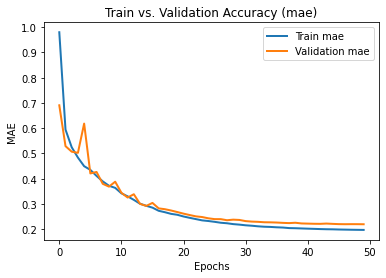

In [ ]:
plt.plot(train_mae1, linewidth=2, label='Train mae'), 
plt.plot(valid_mae1, linewidth=2, label='Validation mae')
plt.ylabel('MAE')
plt.xlabel('Epochs')
plt.title('Train vs. Validation Accuracy (mae)')
plt.legend(loc='upper right')
plt.savefig("Transformer1_val.png")
plt.show()
files.download("Transformer1_val.png") 

In [ ]:
X_test_pred = transformer1.predict(X_test)
transformer1_pred_mae = np.mean(np.abs(X_test_pred - y_test), axis = 1)
transformer1_pred_mae.shape

(15090, 1)

In [ ]:
np.mean(transformer1_pred_mae)

0.2198076675774534

In [ ]:
pred_mae1 = test[["R","C"]][test.index % 80 == 0] 
pred_mae1["mae"] = transformer1_pred_mae
pred_mae1.groupby(['R', 'C']).mean()

mae
R  C           
5  10  0.179236
   20  0.177177
   50  0.225622
20 10  0.193784
   20  0.227235
   50  0.262603
50 10  0.175974
   20  0.280376
   50  0.283115

Text(0.5, 1.0, 'Sample Patient Pressure Prediction')

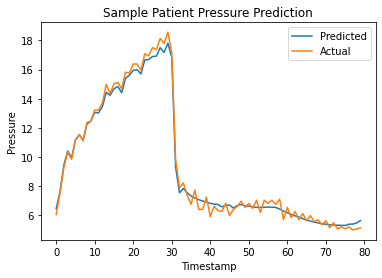

In [ ]:
plt.plot(X_test_pred[0,:], label='Predicted')
plt.plot(y_test[0,:], label='Actual')
plt.xlabel("Timestamp")
plt.ylabel("Pressure")
plt.legend()
plt.title("Sample Patient Pressure Prediction")
plt.savefig("Transformer1_pred.png")
plt.show()
files.download("Transformer1_pred.png") 